# Refactored notebook for modelling

## imports

In [1]:
import sys

sys.path.append("..")

import numpy as np
import pandas as pd
import warnings
import re

from NHS_PROMs.load_data import load_proms, structure_name
from NHS_PROMs.preprocess import filter_in_range, filter_in_labels, method_delta
from NHS_PROMs.utils import downcast, map_labels
from NHS_PROMs.data_dictionary import meta_dict

from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_selector
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.inspection import permutation_importance
from sklearn import set_config
set_config(display='diagram')

from imblearn.over_sampling import SMOTENC
import matplotlib.pyplot as plt
import seaborn as sns

## load data
General approach is not DRY for the sake of availability of having knee and hip df's always at hand, but also keep it readable (script-wise).

In [2]:
# load data + rename columns with structired name
# df_knee_raw = load_proms(part="knee").apply(downcast).rename(structure_name, axis=1)
df_hip_raw = load_proms(part="hip").apply(downcast).rename(structure_name, axis=1)

# get meta data for each
full_meta = {t + k: v for k, v in meta_dict.items() for t in ["t0_", "t1_"]}
hip_meta = {k: v for k, v in full_meta.items() if k in df_hip_raw.columns}

df_hip_raw.sample(3)

,t0_provider_code,t0_procedure,t0_revision_flag,t0_year,t0_age_band,t0_gender,t0_assisted,t0_assisted_by,t0_symptom_period,t0_previous_surgery,...,t1_ohs_transport,t1_ohs_dressing,t1_ohs_shopping,t1_ohs_walking,t1_ohs_limping,t1_ohs_stairs,t1_ohs_standing,t1_ohs_work,t1_ohs_score,t1_ohs_predicted
9871,RBT,Hip Replacement,0,2019/20,70 to 79,2.0,2,0,2,2,...,2,2,1,3,2,2,3,2,24.0,33.852573
1955,RBK,Hip Replacement,0,2018/19,None,NaN,2,0,2,2,...,4,3,3,3,3,3,4,3,39.0,39.637527
13737,RA2,Hip Replacement,0,2017/18,70 to 79,1.0,9,0,1,2,...,3,3,4,4,4,4,4,4,45.0,43.156551


## basic cleaning

In [3]:
endings = (
    "code",
    "procedure",
    "revision_flag",
    "assisted_by",
    "profile",
    "predicted",
)
cols2drop = [c for c in df_hip_raw.columns if c.endswith(endings)]

In [4]:
%%time
df_hip_clean = (
    df_hip_raw.apply(lambda s: filter_in_range(s, **hip_meta[s.name]))
    .apply(lambda s: filter_in_labels(s, **hip_meta[s.name]))
    .apply(lambda s: map_labels(s, **hip_meta[s.name]))
    .query("t0_revision_flag == 'no revision'")
    .drop(columns=cols2drop)
    #     .replace("missing", np.nan)
)

df_hip_clean.sample(3)

CPU times: user 802 ms, sys: 66.7 ms, total: 869 ms
Wall time: 890 ms


,t0_year,t0_age_band,t0_gender,t0_assisted,t0_symptom_period,t0_previous_surgery,t0_living_arrangements,t0_disability,t0_heart_disease,t0_high_bp,...,t1_ohs_washing,t1_ohs_transport,t1_ohs_dressing,t1_ohs_shopping,t1_ohs_walking,t1_ohs_limping,t1_ohs_stairs,t1_ohs_standing,t1_ohs_work,t1_ohs_score
4297,April 2016 - April 2017,50 to 59,female,no,more than 10 years,no,alone,yes,missing,missing,...,sometimes or just at first,rarely/never,rarely/never,rarely/never,rarely/never,rarely/never,rarely/never,rarely/never,sometimes or just at first,46.0
41908,April 2016 - April 2017,70 to 79,female,no,1 to 5 years,no,alone,no,missing,yes,...,rarely/never,sometimes or just at first,"often, not just at first",rarely/never,rarely/never,sometimes or just at first,sometimes or just at first,rarely/never,rarely/never,43.0
32871,April 2016 - April 2017,60 to 69,male,no,1 to 5 years,no,with partner / spouse / family / friends,yes,yes,yes,...,rarely/never,sometimes or just at first,sometimes or just at first,rarely/never,rarely/never,rarely/never,sometimes or just at first,sometimes or just at first,sometimes or just at first,41.0


## split data

In [5]:
#split train + test set
# df_knee_seen = df_knee_clean.query("t0_year != '2019/20'")
# df_knee_unseen = df_knee_clean.query("t0_year == '2019/20'")

df_hip = df_hip_clean.query("t0_year != '2019/20'")
df_hip_unseen = df_hip_clean.query("t0_year == '2019/20'")

df_hip.sample(3)

,t0_year,t0_age_band,t0_gender,t0_assisted,t0_symptom_period,t0_previous_surgery,t0_living_arrangements,t0_disability,t0_heart_disease,t0_high_bp,...,t1_ohs_washing,t1_ohs_transport,t1_ohs_dressing,t1_ohs_shopping,t1_ohs_walking,t1_ohs_limping,t1_ohs_stairs,t1_ohs_standing,t1_ohs_work,t1_ohs_score
18362,April 2018 - April 2019,80 to 89,female,no,1 to 5 years,no,with partner / spouse / family / friends,yes,missing,yes,...,sometimes or just at first,sometimes or just at first,sometimes or just at first,sometimes or just at first,sometimes or just at first,sometimes or just at first,sometimes or just at first,sometimes or just at first,sometimes or just at first,39.0
10450,April 2019 - April 2020,80 to 89,female,no,1 to 5 years,no,alone,yes,missing,missing,...,rarely/never,sometimes or just at first,sometimes or just at first,rarely/never,rarely/never,rarely/never,sometimes or just at first,sometimes or just at first,sometimes or just at first,41.0
21509,April 2018 - April 2019,70 to 79,female,yes,1 to 5 years,no,alone,yes,yes,yes,...,rarely/never,sometimes or just at first,sometimes or just at first,rarely/never,sometimes or just at first,sometimes or just at first,sometimes or just at first,sometimes or just at first,sometimes or just at first,36.0


## create delta dataframes

In [6]:
df_org = df_hip_clean.apply(
    lambda s: map_labels(s, backwards=True, **hip_meta[s.name])
).apply(np.asarray)

# df_knee_delta = method_delta(df_knee_train)
df_hip_delta = method_delta(df_org)

# now you could join them again with the original df ...
# eg: df_hip_clean.join(df_hip_delta)
df_hip_clean = df_hip_clean.join(df_hip_delta)
df_hip_clean.sample(5)

,t0_year,t0_age_band,t0_gender,t0_assisted,t0_symptom_period,t0_previous_surgery,t0_living_arrangements,t0_disability,t0_heart_disease,t0_high_bp,...,delta_ohs_pain,delta_ohs_score,delta_ohs_shopping,delta_ohs_stairs,delta_ohs_standing,delta_ohs_sudden_pain,delta_ohs_transport,delta_ohs_walking,delta_ohs_washing,delta_ohs_work
21100,April 2018 - April 2019,70 to 79,female,no,1 to 5 years,no,with partner / spouse / family / friends,yes,yes,missing,...,4,32.0,2,2,3,2,2,1,3,3
5369,April 2016 - April 2017,60 to 69,female,no,1 to 5 years,no,with partner / spouse / family / friends,yes,missing,missing,...,4,35.0,3,2,3,3,2,4,2,3
4309,April 2016 - April 2017,60 to 69,male,no,more than 10 years,no,with partner / spouse / family / friends,yes,missing,yes,...,3,36.0,3,2,3,4,2,3,2,4
14907,April 2016 - April 2017,70 to 79,male,no,1 to 5 years,no,with partner / spouse / family / friends,no,missing,missing,...,3,36.0,4,2,4,3,3,0,3,4
9110,April 2019 - April 2020,60 to 69,female,no,1 to 5 years,no,with partner / spouse / family / friends,no,missing,yes,...,4,30.0,3,1,4,3,1,1,0,4


In [7]:
df_hip_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 476485 entries, 0 to 44240
Data columns (total 91 columns):
 #   Column                  Non-Null Count   Dtype   
---  ------                  --------------   -----   
 0   t0_year                 476485 non-null  category
 1   t0_age_band             427774 non-null  category
 2   t0_gender               427774 non-null  category
 3   t0_assisted             476485 non-null  category
 4   t0_symptom_period       476485 non-null  category
 5   t0_previous_surgery     476485 non-null  category
 6   t0_living_arrangements  476485 non-null  category
 7   t0_disability           476485 non-null  category
 8   t0_heart_disease        476485 non-null  category
 9   t0_high_bp              476485 non-null  category
 10  t0_stroke               476485 non-null  category
 11  t0_circulation          476485 non-null  category
 12  t0_lung_disease         476485 non-null  category
 13  t0_diabetes             476485 non-null  category
 14  t0_ki

## Make feature set

In [8]:
# print(len(df_hip), "original")
print(len(df_hip.dropna()), "after possible total dropna")
(df_hip.isna().sum() / len(df_hip)).sort_values(ascending=False).head(10)

103346 after possible total dropna


t0_age_band          0.089507
t0_gender            0.089507
t0_eqvas_score       0.089385
t0_eq5d_score        0.056014
t1_eqvas_score       0.047734
t1_eq5d_score        0.042082
t0_ohs_score         0.010959
t1_ohs_score         0.010908
t0_eq5d_mobility     0.000000
t0_eq5d_self_care    0.000000
dtype: float64

In [9]:
# remove NaNs from non categorical/ordinal columns (numerical)
print(len(df_hip), "original")
num_cols = df_hip.select_dtypes(exclude="category").columns
df_hip = df_hip.dropna(subset=num_cols)

print(len(df_hip), "after dropna on numerical")
(df_hip.isna().sum() / len(df_hip)).sort_values(ascending=False).head(10)

139251 original
113818 after dropna on numerical


t0_age_band           0.092007
t0_gender             0.092007
t1_ohs_score          0.000000
t1_assisted           0.000000
t0_eq5d_mobility      0.000000
t0_eq5d_self_care     0.000000
t0_eq5d_activity      0.000000
t0_eq5d_discomfort    0.000000
t0_eq5d_anxiety       0.000000
t0_eq5d_score         0.000000
dtype: float64

In [10]:
# # Buggy: TO DO ...
# # s = df_hip["t0_age_band"]

# # def fillna(s, value):
# #     if s.dtype == "category":
# #         print("is cat")
# #         if value not in s.dtype.categories:
# #             print(value, "not in cats")
# #             display(s.dtype)
# #             display(s.dtype.add_categories(value))
# #             s.add_categories(value, inplace=True)
# #             display(s.dtype)
# #     return s.fillna(value)

# # fillna(s, "missing")

# # status before
# display((df_hip.isna().sum() / len(df_hip)).sort_values(ascending=False).head(10))
# print(len(df_hip), "original")

# # remove NaNs from non categorical/ordinal columns (numerical)
# num_cols = df_hip.select_dtypes(include="number").columns
# df_hip = df_hip.dropna(subset=num_cols).fillna("missing")
# print(len(df_hip), "after dropna on numerical")

## Create Y

### First Y: based on subgroup selection

In [11]:
df_hip_clean['t1_success'].value_counts()

much better        412751
a little better     37004
about the same       9882
missing              6851
a little worse       5559
much worse           4438
Name: t1_success, dtype: int64

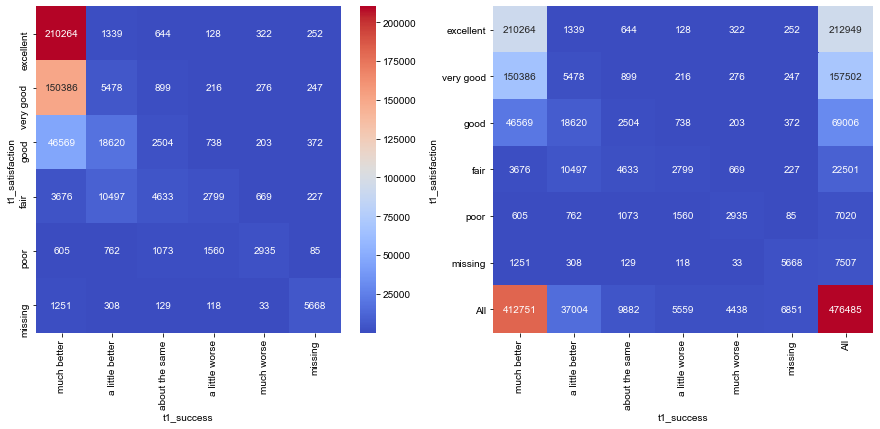

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(15,6))
sns.heatmap(pd.crosstab([df_hip_clean["t1_satisfaction"]], [df_hip_clean["t1_success"]]), cmap="coolwarm", annot=True, cbar=True, fmt='g', ax=ax[0])
sns.heatmap(pd.crosstab([df_hip_clean["t1_satisfaction"]], [df_hip_clean["t1_success"]], margins=True), cmap='coolwarm', annot=True, fmt='g', cbar=False, ax=ax[1])
sns.set(font_scale=1.5)

In [13]:
def success_rec(recode):
    if recode == 'a little worse':
        return 1
    elif recode == 'much worse':
        return 1
#     elif recode == 'about the same':
#         return 1
    else:
        return 0
    
df_hip_clean['success_recode'] = df_hip_clean['t1_success'].apply(success_rec)
df_hip_clean['success_recode'].value_counts(sort=False)

0    466488
1      9997
Name: success_recode, dtype: int64

<Figure size 1080x576 with 0 Axes>

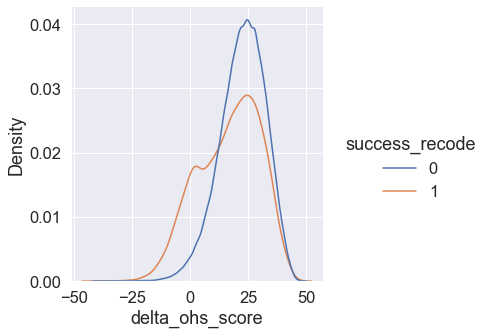

In [14]:
plt.figure(figsize=(15,8))
sns.displot(df_hip_clean, x="delta_ohs_score", hue='success_recode', alpha=.5, kind="kde", common_norm=False);

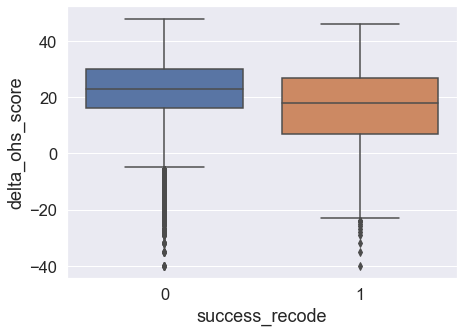

In [15]:
fig, ax = plt.subplots(figsize=(7,5))
fig = sns.boxplot(x=df_hip_clean["success_recode"], y=df_hip_clean['delta_ohs_score'], data=df_hip_clean)

In [16]:
df_hip_clean['diff_ohs'] = df_hip_clean['t1_ohs_score'] - df_hip_clean['t0_ohs_score']

<Figure size 1080x576 with 0 Axes>

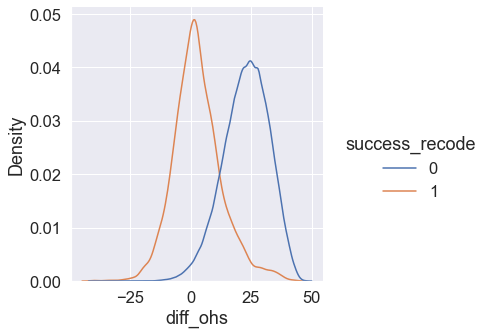

In [17]:
plt.figure(figsize=(15,8))
sns.displot(df_hip_clean, x="diff_ohs", hue='success_recode', alpha=.5, kind="kde", common_norm=False);

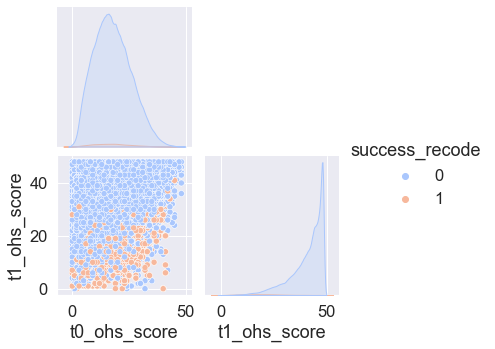

In [18]:
sns.pairplot(data=df_hip_clean[['t0_ohs_score','t1_ohs_score', 'success_recode']],hue='success_recode', palette="coolwarm", corner=True);

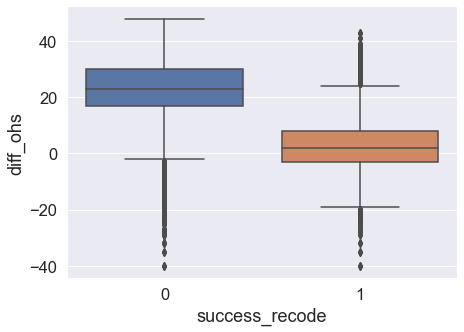

In [19]:
fig, ax = plt.subplots(figsize=(7,5))
fig = sns.boxplot(x=df_hip_clean["success_recode"], y=df_hip_clean['diff_ohs'], data=df_hip_clean)

In [20]:
df_hip_clean['diff_ohs'].groupby(df_hip_clean['success_recode']).mean()

success_recode
0    22.896961
1     2.952104
Name: diff_ohs, dtype: float32

In [44]:
# def success_rec(recode):
#     if recode == 'a little worse':
#         return 1
#     elif recode == 'much worse':
#         return 1
# #     elif recode == 'about the same':
# #         return 1
#     else:
#         return 0
    
# df_hip['success_recode'] = df_hip['t1_success'].apply(success_rec)
# df_hip['success_recode'].value_counts(sort=False)

In [45]:
df_hip = df_hip.dropna().sample(10_000) # dirty drop for the sake of testing pl

# create x, y
X = df_hip.filter(regex="t0")
y = (df_hip["t1_ohs_score"] - df_hip["t0_ohs_score"] <= 3).astype(int) # hip <= 3
# y = (df_hip["success_recode"] == 1).astype(int) # hip <= 3

# create train, test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42, stratify=y
)

## show OHE

In [46]:
# example to show it works
OHE = OneHotEncoder(sparse=False, dtype="uint8")
OHE.fit(X_train)

pd.DataFrame(
    data=OHE.transform(X_train),
    index=X_train.index,
    columns=OHE.get_feature_names(X_train.columns),
)

,t0_year_April 2016 - April 2017,t0_year_April 2017 - April 2018,t0_year_April 2018 - April 2019,t0_year_April 2019 - April 2020,t0_age_band_20 to 29,t0_age_band_30 to 39,t0_age_band_40 to 49,t0_age_band_50 to 59,t0_age_band_60 to 69,t0_age_band_70 to 79,...,t0_ohs_score_38.0,t0_ohs_score_39.0,t0_ohs_score_40.0,t0_ohs_score_41.0,t0_ohs_score_42.0,t0_ohs_score_43.0,t0_ohs_score_44.0,t0_ohs_score_45.0,t0_ohs_score_47.0,t0_ohs_score_48.0
21916,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10598,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
17233,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
22446,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3808,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21172,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
10931,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
8029,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
32079,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


## make balanced

In [47]:
print("before:")
display(y_train.value_counts())

cat_cols = X_train.dtypes == "category"

resampler = SMOTENC(categorical_features=cat_cols.values)
X_train_balanced, y_train_balanced = resampler.fit_resample(X_train, y_train)

print("after:")
display(y_train_balanced.value_counts())

before:


0    6422
1     278
dtype: int64

after:


1    6422
0    6422
dtype: int64

## make + train a simple pipeline

In [48]:
from sklearn.ensemble import AdaBoostClassifier

In [49]:
# make the pipeline
ct = make_column_transformer(
    (OneHotEncoder(), make_column_selector(dtype_include="category")),
    (StandardScaler(), make_column_selector(dtype_include="number")),
) 

pl = make_pipeline(ct, AdaBoostClassifier())

# train the pipeline/model
pl.fit(X_train_balanced, y_train_balanced)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fa6225a1250>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fa6225a1a90>)])),
                ('adaboostclassifier', AdaBoostClassifier())])

## predict + evaluate

In [50]:
# make prediction
y_hat = pl.predict(X_test.head(500))

# evaluate
print(classification_report(y_test.head(500), y_hat))

              precision    recall  f1-score   support

           0       0.97      0.82      0.88       477
           1       0.09      0.39      0.15        23

    accuracy                           0.80       500
   macro avg       0.53      0.60      0.52       500
weighted avg       0.93      0.80      0.85       500



## extract feature names pl

In [28]:
# get the feature names from pipeline
def get_feature_names(sklobj, feature_names=[]):

    if isinstance(sklobj, Pipeline):
        for name, step in sklobj.steps:
            get_feature_names(step, feature_names)
    elif isinstance(sklobj, ColumnTransformer):
        for name, transformer, columns in sklobj.transformers_:
            feature_names += get_feature_names(transformer, columns)
    elif isinstance(sklobj, OneHotEncoder):
        feature_names = sklobj.get_feature_names(feature_names).tolist()
    elif isinstance(sklobj, str):
        if sklobj == "passthrough":
            pass
        elif sklobj == "drop":
            feature_names = []
            
    return feature_names

In [29]:
get_feature_names(pl)

['t0_year_April 2016 - April 2017',
 't0_year_April 2017 - April 2018',
 't0_year_April 2018 - April 2019',
 't0_year_April 2019 - April 2020',
 't0_age_band_20 to 29',
 't0_age_band_30 to 39',
 't0_age_band_40 to 49',
 't0_age_band_50 to 59',
 't0_age_band_60 to 69',
 't0_age_band_70 to 79',
 't0_age_band_80 to 89',
 't0_age_band_90 to 120',
 't0_gender_female',
 't0_gender_male',
 't0_assisted_missing',
 't0_assisted_no',
 't0_assisted_yes',
 't0_symptom_period_1 to 5 years',
 't0_symptom_period_6 to 10 years',
 't0_symptom_period_less than 1 year',
 't0_symptom_period_missing',
 't0_symptom_period_more than 10 years',
 't0_previous_surgery_missing',
 't0_previous_surgery_no',
 't0_previous_surgery_yes',
 't0_living_arrangements_alone',
 't0_living_arrangements_in a nursing home, hospital or other long-term care home',
 't0_living_arrangements_missing',
 't0_living_arrangements_other',
 't0_living_arrangements_with partner / spouse / family / friends',
 't0_disability_missing',
 't0_

In [30]:
# # this is slow ...
# r = permutation_importance(pl, X_train.head(1_000), y_train.head(1_000), n_repeats=2, random_state=0)

# feature_names = get_feature_names(pl)

# for i in r.importances_mean.argsort()[::-1]:
#     if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
#         print(f"{feature_names[i]:<8}"
#         f"{r.importances_mean[i]:.3f}"
#         f" +/- {r.importances_std[i]:.3f}")

## a more advanced pipeline

In [31]:
# TO DO ...

## debug issue

In [32]:
data = list("abcebdebca")
categories = list("abcd")

In [33]:
cats = pd.Categorical(data, categories=categories, ordered=True)
s1 = pd.Series(cats)

display(s1)
s1.cat.categories

0      a
1      b
2      c
3    NaN
4      b
5      d
6    NaN
7      b
8      c
9      a
dtype: category
Categories (4, object): ['a' < 'b' < 'c' < 'd']

Index(['a', 'b', 'c', 'd'], dtype='object')

In [34]:
from pandas.api.types import CategoricalDtype
cat_type = CategoricalDtype(categories=categories, ordered=True)
s2 = pd.Series(data).astype(cat_type)

display(s2)
s2.cat.categories

0      a
1      b
2      c
3    NaN
4      b
5      d
6    NaN
7      b
8      c
9      a
dtype: category
Categories (4, object): ['a' < 'b' < 'c' < 'd']

Index(['a', 'b', 'c', 'd'], dtype='object')

In [35]:
s3 = pd.Series(data).astype("category")

display(s3)
s3.cat.categories

0    a
1    b
2    c
3    e
4    b
5    d
6    e
7    b
8    c
9    a
dtype: category
Categories (5, object): ['a', 'b', 'c', 'd', 'e']

Index(['a', 'b', 'c', 'd', 'e'], dtype='object')